<a href="https://colab.research.google.com/github/johanlopezs/YOLO_microorganism/blob/modificacion_yolo/Tutorial_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **<center>TUTORIAL PARA ENTRENAR Y REALIZAR PREDICCIONES CON YOLOv5.</center>**


* Clonar el repositorio almacenaod en el link: https://github.com/johanlopezs/YOLO_microorganism.git.

* Instalar las dependencias necesarias e importar las librerias.   




In [5]:
%%capture
!git clone https://github.com/johanlopezs/YOLO_microorganism.git
%cd /content/YOLO_microorganism
%pip install -qr requirements.txt
!pip install zenodo_get
!pip install rarfile
import torch
import os
import zenodo_get
import rarfile


Ambos set de datos se encunetran almacenados en drive. se debe de dar acceso primero, luego elegir el set de datos a usar. Hay dos opciones: 

* **optical_microscopy_images**: Imagenes de microscopia convencional 520 imagenes de forma (640, 640, 3) RGB 
* **phase_contrast_microscopy_images**: Imagenes de microscopia de contrastre de fases aproximadamente 1206 imagenes de forma (640,640,3) RGB

In [10]:
from google.colab import drive
drive.mount('/content/drive')
import shutil

name_path = 'optical_microscopy_images' #@param ['optical_microscopy_images', 'phase_contrast_microscopy_images']
# Ruta de la carpeta que deseas copiar
org_path = '/content/drive/MyDrive/' + name_path
# Ruta de la carpeta destino
dest_path = '/content/YOLO_microorganism/' + name_path
# Copiar la carpeta de origen a la carpeta destino
shutil.copytree(org_path, dest_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/YOLO_microorganism/optical_microscopy_images'


**BASE DE DATOS ZENODO**

Esta seccion de codigo solo se podra usar cuando el set de datos se haga **publico** en zenodo. Esta seccion importa ambos set de datos de Zenodo y los almacena en la misma ubicación que que lo hace la linea anterior de drive 


In [ ]:
# # nos ubicamos en el lugar en donde se descargaran los datos.
%cd /content/YOLO_microorganism
# # usando la funcion zenodo_get descargamos la base de datos.
!zenodo_get https://zenodo.org/record/7657731

# descomprimimos el archivo .rar
# Creamos un objeto de tipo RarFile con la ruta al archivo .rar que queremos descomprimir
file_rar = rarfile.RarFile("Cryptosporidium.rar")
# # Extraemos el contenido del archivo .rar a una carpeta
file_rar.extractall("/content/YOLO_microorganism")

**Elegir base de datos a usar**

* Si el set de datos se descargo de **Drive** se debe de usar este mismo en esta seccion de codigo. 

* Para set de datos importado en **Zenodo** se debe de elegir cual de los dos set de datos se van a usar.

/content/YOLO_microorganism
----------------optical_microscopy_images-----------------------------
names:
- Giardia
- C. parvum
nc: 2
train: optical_microscopy_images/train/images
val: optical_microscopy_images/valid/images


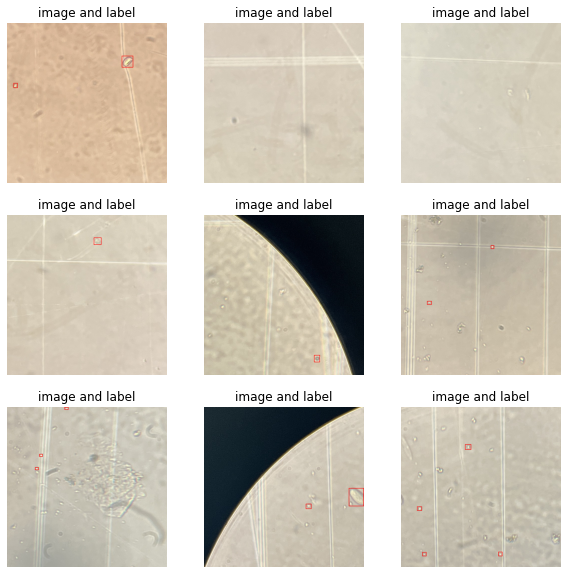

In [11]:
# verificamos la informacion en cada uno de los set de datos en los archivos .yaml
dataset = 'optical_microscopy_images' #@param ['optical_microscopy_images', 'phase_contrast_microscopy_images']
%cd /content/YOLO_microorganism
if dataset == 'optical_microscopy_images':
  print ('----------------optical_microscopy_images-----------------------------')
  !cat optical_microscopy_images/data.yaml
else: 
  print ('\n-----------------phase_contrast_microscopy_images----------------------------')
  !cat phase_contrast_microscopy_images/data.yaml

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def yolo_to_xml_bbox(bbox, w, h):
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


def draw_image(img, bboxes):
    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
        draw.rectangle(bbox, outline="red", width=2)
    plt.imshow(img)
    plt.title('image and label')
    plt.axis('off')
    plt.show

images_dir = dataset + '/valid/images/'
images = !ls -1 '{images_dir}'
labels_dir = dataset +'/valid/labels/'
labels = !ls -1 '{labels_dir}'

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  bboxes = []
  img = Image.open(images_dir + images[i])
  if os.path.getsize(labels_dir + labels[i]) > 5:
    with open(labels_dir + labels[i], 'r', encoding='utf8') as f:
        for line in f:
            data = line.strip().split(' ')
            bbox = [float(x) for x in data[1:]]
            bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))
  draw_image(img, bboxes)


## **Seleccionar entre los 3 modelos: [YOLOs, YOLOm y YOLOl]**


La red se puede entrenar la red se pueden usar cualquiera de los 3 modelos nombrados a continuacion:

* YOLOs
* YOLOm
* YOLOl

En la celda **epochs_** se escribe el numero de epocas de entrenamiento del modelo.

Los hiperparametros que se usaran para el entrenamiento son los que se han probado y han dado mejores resultados para esta eplicacion en especifico.


In [17]:
%cd /content/YOLO_microorganism
model = 'YOLOs' #@param['YOLOs', 'YOLOm','YOLOl']
epochs_ = 10 #@param {type: 'integer'}
datos = 'optical_microscopy_images'
if model == 'YOLOs':
  !python train.py --img 640 --batch 16 --epochs $epochs_ --data {dataset}/data.yaml --weights yolov5s.pt --cache  
elif model == 'YOLOm':
  !python train.py --img 640 --batch 16 --epochs $epochs_ --data {dataset}/data.yaml --weights yolov5m.pt --cache
elif model == 'YOLOl':
  !python train.py --img 640 --batch 16 --epochs $epochs_ --data {dataset}/data.yaml --weights yolov5l.pt --cache


/content/YOLO_microorganism
train: weights=yolov5s.pt, cfg=, data=optical_microscopy_images/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 15236, done.
remote: Total 15236 (delta 0), reused 0 (delta 0), pack-reused 15236
Receiving objects: 100% (15236/15236), 14.16 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (10448/10448), done.
From https://github.com/ultralytics/yolov5
 * [new branch]      add/weights_dir   -> ultralytics/add/weights_dir
 * [new branch]      ben

# realizar prediciones

In [ ]:
runs = 'runs/train'
names = !ls -1 '{runs}'
print('Lista de exprimentos')
for i in names:
  print(runs + '/' + i)

Lista de exprimentos
runs/train/exp


Aqui se debe de poner la ruta con el exprimento con el cual se planea hacer la prediccion. 

In [ ]:
Experiment = 'runs/train/exp' #@param {type:"string"}
subfolder_name = Experiment + '/weights/last.pt'
route_weights = os.path.join(subfolder_name)
source_ = dataset + '/test/images'
source_ = os.path.join(source_)
%cd /content/YOLO_microorganism
!python detect.py --weights $route_weights --img 640 --conf 0.1 --source $source_


/content/YOLO_microorganism
detect: weights=['runs/train/exp/weights/last.pt'], source=optical_microscopy_images/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 28b27bb Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/52 /content/YOLO_microorganism/optical_microscopy_images/test/images/112color.jpg: 640x640 (no detections), 12.7ms
image 2/52 /content/YOLO_microorganism/optical_microscopy_images/test/images/128color.jpg: 640x640 19 C. parvums, 12.7ms
image 3/52 /content/YOLO_microorganism/optical_microscopy_images/te

In [ ]:
predict = 'runs/detect'
names = !ls -1 '{predict}'
for i in names:
  print(predict + '/' + i)

runs/detect/exp
runs/detect/exp2


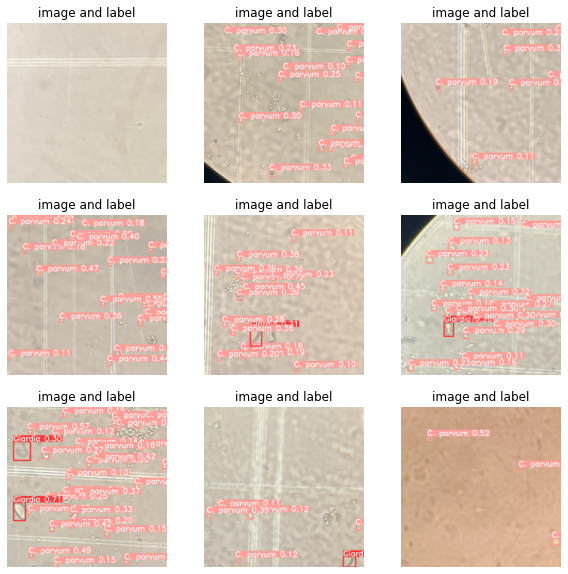

In [ ]:
img_route = 'runs/detect/exp2' #@param {type:'string'}
images_ = !ls -1 '{img_route}'

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  img = Image.open(img_route + '/' + images_[i])
  plt.imshow(img)
  plt.title('image and label')
  plt.axis('off')
  plt.show
